# Mapping the Landscape of Generative AI Research through Web of Science

### 1. Introduction

In the rapidly evolving field of generative artificial intelligence (AI), identifying key research themes and understanding their interconnections is crucial for academics, practitioners, and policymakers. This project aims to utilize the comprehensive Web of Science (WoS) database to search for publications related to generative AI. Through an analytical approach focused on keyword co-occurrence networks derived from author keywords, we will map the intellectual structure and identify the core themes and trends in generative AI research.

With this project, we aim to understand the evolution of 'Generative AI' over the years and understand its emergence into different fields of study, by creating a co-occurrence matrix and network graph analysis.

### 2. Data Collection

We start by downloading all the relevant articles and their metadata, which includes searching for key terms like 'Generative AI', 'Generative Artificial Intelligence', 'Gen-AI', and 'Generative Machine Learning' in the Web of Science (WOS) portal.

For this project, we have downloaded nearly 25,000 articles from the WOS portal using the search terms related to 'Generative AI'. The maximum number of files that could be downloaded in one export was 1000, which resulted in 25 different files with 100 articles in each file. These files are combined into a single data file. Since the search terms are related to each other, there could be duplicate articles downloaded for each search term. Hence we drop duplicate articles identified using the UT(Unique WOS ID) field. 

For this particular analysis, we only need certain fields like Author Keywords, Keyword Plus, Published Year, and Research Area, therefore, we drop all the extra columns to reduce the memory computation.

In [51]:
#Import relevant libraries
import os
import re
import csv
import math
import base64
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import dash_bootstrap_components as dbc

import warnings
warnings.filterwarnings('ignore')

In [52]:
# Path to the folder containing the input files and output files
input_path = "Data/"
output_path = "Processed_Data/"

In [53]:
# Loop through all the files in the input folder to combine them and remove duplicates

# List to store dataframes
dfs = []

# Iterate over each file in the directory
for file in os.listdir(input_path):
    if file.endswith('.xlsx') or file.endswith('.xls'):
        # Read Excel file into a dataframe
        df = pd.read_excel(os.path.join(input_path, file))
        # Append dataframe to the list
        dfs.append(df)

# Concatenate dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

#Remove any depulicate articles that are common between different search term downloads
combined_df = combined_df.drop_duplicates(subset=['UT (Unique WOS ID)'])

# Save combined dataframe to a CSV file
combined_df.to_csv(output_path + 'combined_data.csv', index=False)


We keep only relevant fields in the dataframe, drop any NA values from the keyword columns and create 'Keywords' columns by combining 'Author Keyword' and 'Keyword Plus' column

In [54]:
# Retain only the relevant fields

equired_df = combined_df[['Article Title','Author Keywords','Keywords Plus','Funding Orgs','Publication Year','Research Areas','UT (Unique WOS ID)']]
# Fill NaN values with empty string
required_df['Author Keywords'].fillna('', inplace=True)
required_df['Keywords Plus'].fillna('', inplace=True)
required_df['Keywords'] = required_df['Author Keywords'] + ';' + required_df['Keywords Plus']

required_df.to_csv(output_path + 'required_df.csv', index=False)
required_df.head()

,Article Title,Author Keywords,Keywords Plus,Funding Orgs,Publication Year,Research Areas,UT (Unique WOS ID),Keywords
0,Adversarial Directed Graph Embedding,,,"Natural Science Foundation of China [61872022,...",2021,Computer Science; Education & Educational Rese...,WOS:000680423504097,;
1,An Optimized Training Method for GAN-Based Hyp...,Training; Gallium nitride; Generative adversar...,SPATIAL CLASSIFICATION,National Natural Science Foundation of China [...,2021,Geochemistry & Geophysics; Engineering; Remote...,WOS:000701254500027,Training; Gallium nitride; Generative adversar...
2,Generation of Load Profile Based on GAN and LS...,Generative Adversarial Network; Long Short Ter...,,NaN,2023,Construction & Building Technology; Engineering,WOS:001054860600079,Generative Adversarial Network; Long Short Ter...
3,Extreme scenario generation for renewable ener...,artificial intelligence and data analytics; re...,,NaN,2023,Engineering,WOS:001022714100001,artificial intelligence and data analytics; re...
4,How Do We Move: Modeling Human Movement with S...,,,"NSF [1652525, 1618448]; Div Of Information & I...",2021,Computer Science; Education & Educational Rese...,WOS:000680423504063,;


### 3. Data Preprocessing

Once we have the 'Keyword' column for all the articles, we need to clean this column to remove duplicates, standardize the abbreviated values, and remove special characters for each article.

This includes several string operations performed on each keyword of the article like,
- Splitting the keywords string with ';' delimiter
- Split any keywords enclosed in brackets '()'
- Remove all special characters, numbers, and trailing and leading spaces
- Change keyword case to lower to remove case sensitivity issue
- Lemmatize the keyword to bring it to the root word format keeping contextual meaning intact
- Remove empty strings and stop words

#### 3.1 Removing stop words

Stop word removal is a critical preprocessing step in natural language processing (NLP) aimed at eliminating common words that carry little semantic meaning. By discarding these words, the focus shifts to content words, enhancing the quality and relevance of text analysis. This process not only reduces noise, it also streamlines the dataset and concentrates on informative terms. 

In this context and analysis, words like model, algorithm, design, system, etc., carry littel to no meaning to the problem at hand. We collect a list of these words from the unique keyword list and remove them from each article's keyword composition. 

In [55]:
# Clean the article keywords and create a new field

required_df = pd.read_csv(output_path+'required_df.csv')
required_df = required_df[required_df['Keywords']!=';']

stop_words_df = pd.read_csv((output_path+'stop_words.csv'))
stop_words = stop_words_df['stop_words'].to_list()
#print(stop_words)
keyword_list = []

 # Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Loop through rows in dataframe
for index, row in required_df.iterrows():
    item = row['Keywords']
    item_index = index 
    keyword_list = []
    keyword = item.split(';')
    
    # Loop through each keyword
    for word in keyword:
        new_word = [x.strip() for x in word.split('(') if x.strip()]
        keyword_list.extend(new_word)

    # Perform string cleaning operations
    cleaned_list = [re.sub(r'[^a-zA-Z\s]', '', item) for item in keyword_list]
    stripped_list = [item.strip() for item in cleaned_list]
    lower_list = [x.lower() for x in stripped_list]
    lemmatized_list = [lemmatizer.lemmatize(word) for word in keyword]
    unique_list = list(set(lower_list))
    length_list = [value for value in unique_list if len(value) > 1]
    #print(length_list)
    filtered_words = [word for word in length_list if word.lower() not in stop_words]
    #print(filtered_words)

    # Combine all the keywords for an article 
    combined_string = ';'.join(filtered_words)
    required_df.at[item_index, 'Clean Keywords'] = combined_string
    #required_df['Clean Keywords'] = combined_string

required_df.to_csv(output_path + 'required_df.csv', index=False)
required_df.head()

,Article Title,Author Keywords,Keywords Plus,Funding Orgs,Publication Year,Research Areas,UT (Unique WOS ID),Keywords,Clean Keywords
1,An Optimized Training Method for GAN-Based Hyp...,Training; Gallium nitride; Generative adversar...,SPATIAL CLASSIFICATION,National Natural Science Foundation of China [...,2021,Geochemistry & Geophysics; Engineering; Remote...,WOS:000701254500027,Training; Gallium nitride; Generative adversar...,image resolution;gan;hsi classification;task a...
2,Generation of Load Profile Based on GAN and LS...,Generative Adversarial Network; Long Short Ter...,NaN,NaN,2023,Construction & Building Technology; Engineering,WOS:001054860600079,Generative Adversarial Network; Long Short Ter...,long short term memory;load profile generation...
3,Extreme scenario generation for renewable ener...,artificial intelligence and data analytics; re...,NaN,NaN,2023,Engineering,WOS:001022714100001,artificial intelligence and data analytics; re...,renewable energy sources;artificial intelligen...
5,Machine-Generated Text: A Comprehensive Survey...,Artificial intelligence; cybersecurity; disinf...,NaN,Natural Sciences and Engineering Research Coun...,2023,Computer Science; Engineering; Telecommunications,WOS:001033493400001,Artificial intelligence; cybersecurity; disinf...,generative ai;large language models;machine le...
6,CNNs Combined With a Conditional GAN for Mura ...,Thin film transistors; Training; Generators; T...,NaN,"Ministry of Science and Technology, Taiwan [MO...",2021,Engineering; Physics,WOS:000615040700004,Thin film transistors; Training; Generators; T...,transfer learning;noise reduction;ensemble lea...


In [56]:
# Function to create a list of unique values split with ';' delimiter

def unique_list_generator(df):
    keyword_list = []

    # Loop through rows in dataframe
    for item in df.iloc[:, 0]:
        if not pd.isna(item):
            keyword = item.split(';')
            keyword_list.extend(keyword)

    #print(len(keyword_list))
    unique_list, counts = np.unique(keyword_list,return_counts=True)

    return unique_list,counts

A new column 'Clean Keywords' is created by performing all the string cleaning operations. This newly created column will now be used for the further analysis.

In [57]:
# Create a list of unique cleaned keywords to prepare mapping dictionary

clean_keywords = required_df[['Clean Keywords']]

unique_list,counts = unique_list_generator(clean_keywords)

with open(output_path + 'unique_list.csv', "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows([[item1,item2] for item1,item2 in zip(unique_list,counts)])

### 4. Creating a mapping dictionary

As a next step, we need to convert all the similar terms to the same word, for example, 'Generative AI', 'Generative Artificial Intelligence', and 'Gen AI' are all the same words represented in different ways, which needs to be converted to one common word. This is achieved by creating a mapping dictionary on top of the unique word list.

We have created a mapping dictionary manually by mapping the top 80% of the most frequently occurring unique words. There were no NLP libraries that could readily create the mapping dictionary for the context of this analysis.

The below screenshot shows the different uses of the word 'chat gpt' which is mapped to 'ChatGPT'. Any different keywords like 'chat gpt bard' will be retained to preserve their frequency information.

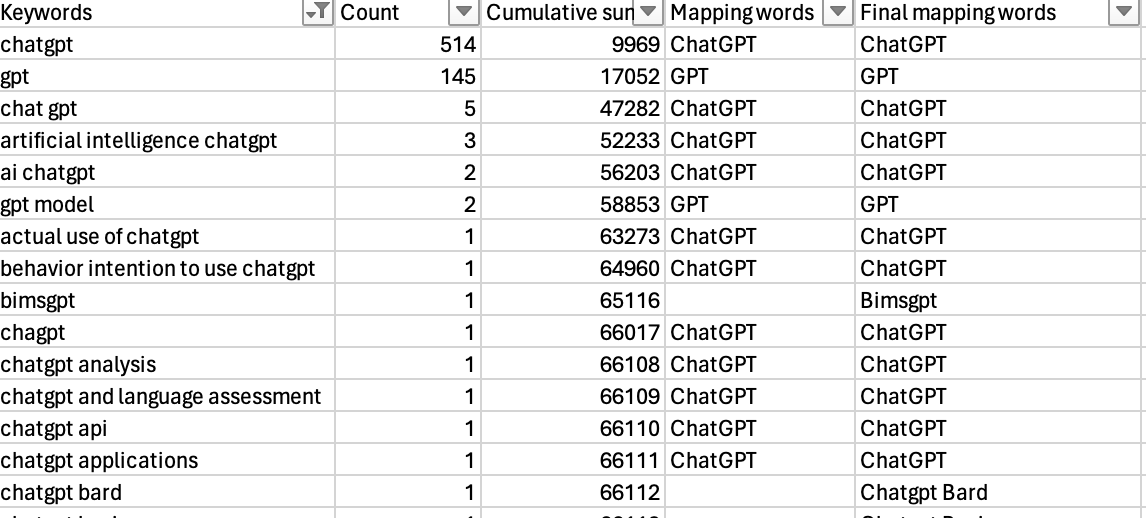

In [58]:
# Map the keywords based on the mapping dictionary

thesaurus = pd.read_csv(output_path+'thesaurus.csv')
mapping_dict = dict(zip(thesaurus['Keywords'], thesaurus['Final mapping words']))

#Loop through rows in dataframe
for index, row in required_df.iterrows():
    item = row['Clean Keywords']
    item_index = index 
    new_list = []

    keyword = item.split(';')
    if len(keyword) > 1:
        #print(keyword)
        new_list = [mapping_dict[val] for val in keyword]
    unique_list = list(set(new_list))
    cleaned_list = [x for x in unique_list if not isinstance(x, float) or not math.isnan(x)]
    #print(new_list)

    combined_string = ';'.join(cleaned_list)
    required_df.at[item_index, 'Mapped Keywords'] = combined_string
        
required_df.to_csv(output_path + 'required_df.csv', index=False)
required_df.head()

,Article Title,Author Keywords,Keywords Plus,Funding Orgs,Publication Year,Research Areas,UT (Unique WOS ID),Keywords,Clean Keywords,Mapped Keywords
1,An Optimized Training Method for GAN-Based Hyp...,Training; Gallium nitride; Generative adversar...,SPATIAL CLASSIFICATION,National Natural Science Foundation of China [...,2021,Geochemistry & Geophysics; Engineering; Remote...,WOS:000701254500027,Training; Gallium nitride; Generative adversar...,image resolution;gan;hsi classification;task a...,Image Processing;GAN;Hyperspectral Imaging;Hyp...
2,Generation of Load Profile Based on GAN and LS...,Generative Adversarial Network; Long Short Ter...,NaN,NaN,2023,Construction & Building Technology; Engineering,WOS:001054860600079,Generative Adversarial Network; Long Short Ter...,long short term memory;load profile generation...,GAN;Long Short Term Memory;Datadriven;Load Pro...
3,Extreme scenario generation for renewable ener...,artificial intelligence and data analytics; re...,NaN,NaN,2023,Engineering,WOS:001022714100001,artificial intelligence and data analytics; re...,renewable energy sources;artificial intelligen...,Renewable Energy Sources;Artificial Intelligen...
5,Machine-Generated Text: A Comprehensive Survey...,Artificial intelligence; cybersecurity; disinf...,NaN,Natural Sciences and Engineering Research Coun...,2023,Computer Science; Engineering; Telecommunications,WOS:001033493400001,Artificial intelligence; cybersecurity; disinf...,generative ai;large language models;machine le...,LLM;Cybersecurity;Threat Modeling;Text Generat...
6,CNNs Combined With a Conditional GAN for Mura ...,Thin film transistors; Training; Generators; T...,NaN,"Ministry of Science and Technology, Taiwan [MO...",2021,Engineering; Physics,WOS:000615040700004,Thin film transistors; Training; Generators; T...,transfer learning;noise reduction;ensemble lea...,Tftlcd;Transfer Learning;GAN;Thin Film Transis...


Using the mapping dictionary, we create a new field called 'Mapped Keyword' and remove duplicates in this field for further analysis.

In [59]:
# Create a list of unique cleaned, mapped keywords for further analysis

mapped_keywords = required_df[['Mapped Keywords']]

unique_list,counts = unique_list_generator(mapped_keywords)

# Add unique list to dataframe with count to sort 
unique_df = pd.DataFrame({'unique_list': unique_list, 'counts': counts})
unique_df = unique_df.drop(unique_df.index[0])
unique_df = unique_df.sort_values(by='counts',ascending=False)

overall_keywords =  (unique_df['unique_list']).to_list()

# Get the top 20 keywords 
top_keywords = (unique_df['unique_list'].head(20)).to_list()

### 5. Create a co-occurance matrix

Using the unique list of cleaned, mapped keywords, create a co-occurrence matrix. With the help of a co-occurnace matrix, we can understand how different pairs of keywords occur together in a document.

After we create the co-occurrence matrix, we plot the top 20/30 keywords as a network graph, to understand the keywords that are related and co-occur frequently in documents.

In [75]:
#Function to create a co-occurance matrix, given a list of keywords

def create_coocuurance_matrix(list):
    # Initialize an empty adjacency matrix
    n = len(list)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    #print(adjacency_matrix)

    # Calculate edit distance between each pair of words
    for i in range(n):
        for j in range(i+1, n):
            for val in required_df['Mapped Keywords']:
                #print(val)
                if list[i] in val and list[j] in val:
                    adjacency_matrix[i, j] += 1
                    adjacency_matrix[j, i] += 1

    #print(adjacency_matrix)
    df = pd.DataFrame(adjacency_matrix, index=list)
    df.columns = list

    return df

In [76]:
# Function to create a network graph given a co-occurance matrix

def plot_network(co_matrix):
    # Create an empty graph
    G = nx.Graph()

    # Add edges based on the co-occurrence matrix
    for i in range(len(co_matrix)):
        for j in range(i+1, len(co_matrix.columns)):
            weight = co_matrix.iloc[i, j]
            if weight > 0:
                G.add_edge(co_matrix.index[i], co_matrix.columns[j], weight=weight)

    # Calculate the total co-occurrence count for each node
    total_co_count = co_matrix.sum(axis=1).tolist()
    num_nodes = len(co_matrix)
    node_colors = [plt.cm.Greens(i / num_nodes) for i in range(num_nodes)][::-1]

    # Draw the graph with custom node labels
    plt.figure(figsize=(10, 6))  # Set the figure size
    pos = nx.spring_layout(G)  # Layout for the graph
    nx.draw(G, pos, with_labels=True, node_color=node_colors , node_size=total_co_count, font_size=10, font_weight='bold')
    plt.show()


We can use the create_co-occurance_matrix function to create a frequency matrix for the top 400 words and the plot_network function to plot a network graph for the top 20 keywords related to 'Generative AI'. In the image below, we can see the top keywords and their co-occurrence frequency highlighted by heatmap, and the top co-occurances are highlighted in green.

From this, we can see,
1. 'Generative AI' and 'AI' co-occur 1800 times and is the top keyword pair
2. 'Image' and 'GAN' (Generative Adversarial Network) co-occur 1246 times 
3. 'Deep Learning' and 'GAN' co-occur 1046 times

In [77]:
matrix_list = overall_keywords[:400]
df = create_coocuurance_matrix(matrix_list)
df.to_csv(output_path+'adjacency_matrix.csv', index=True)

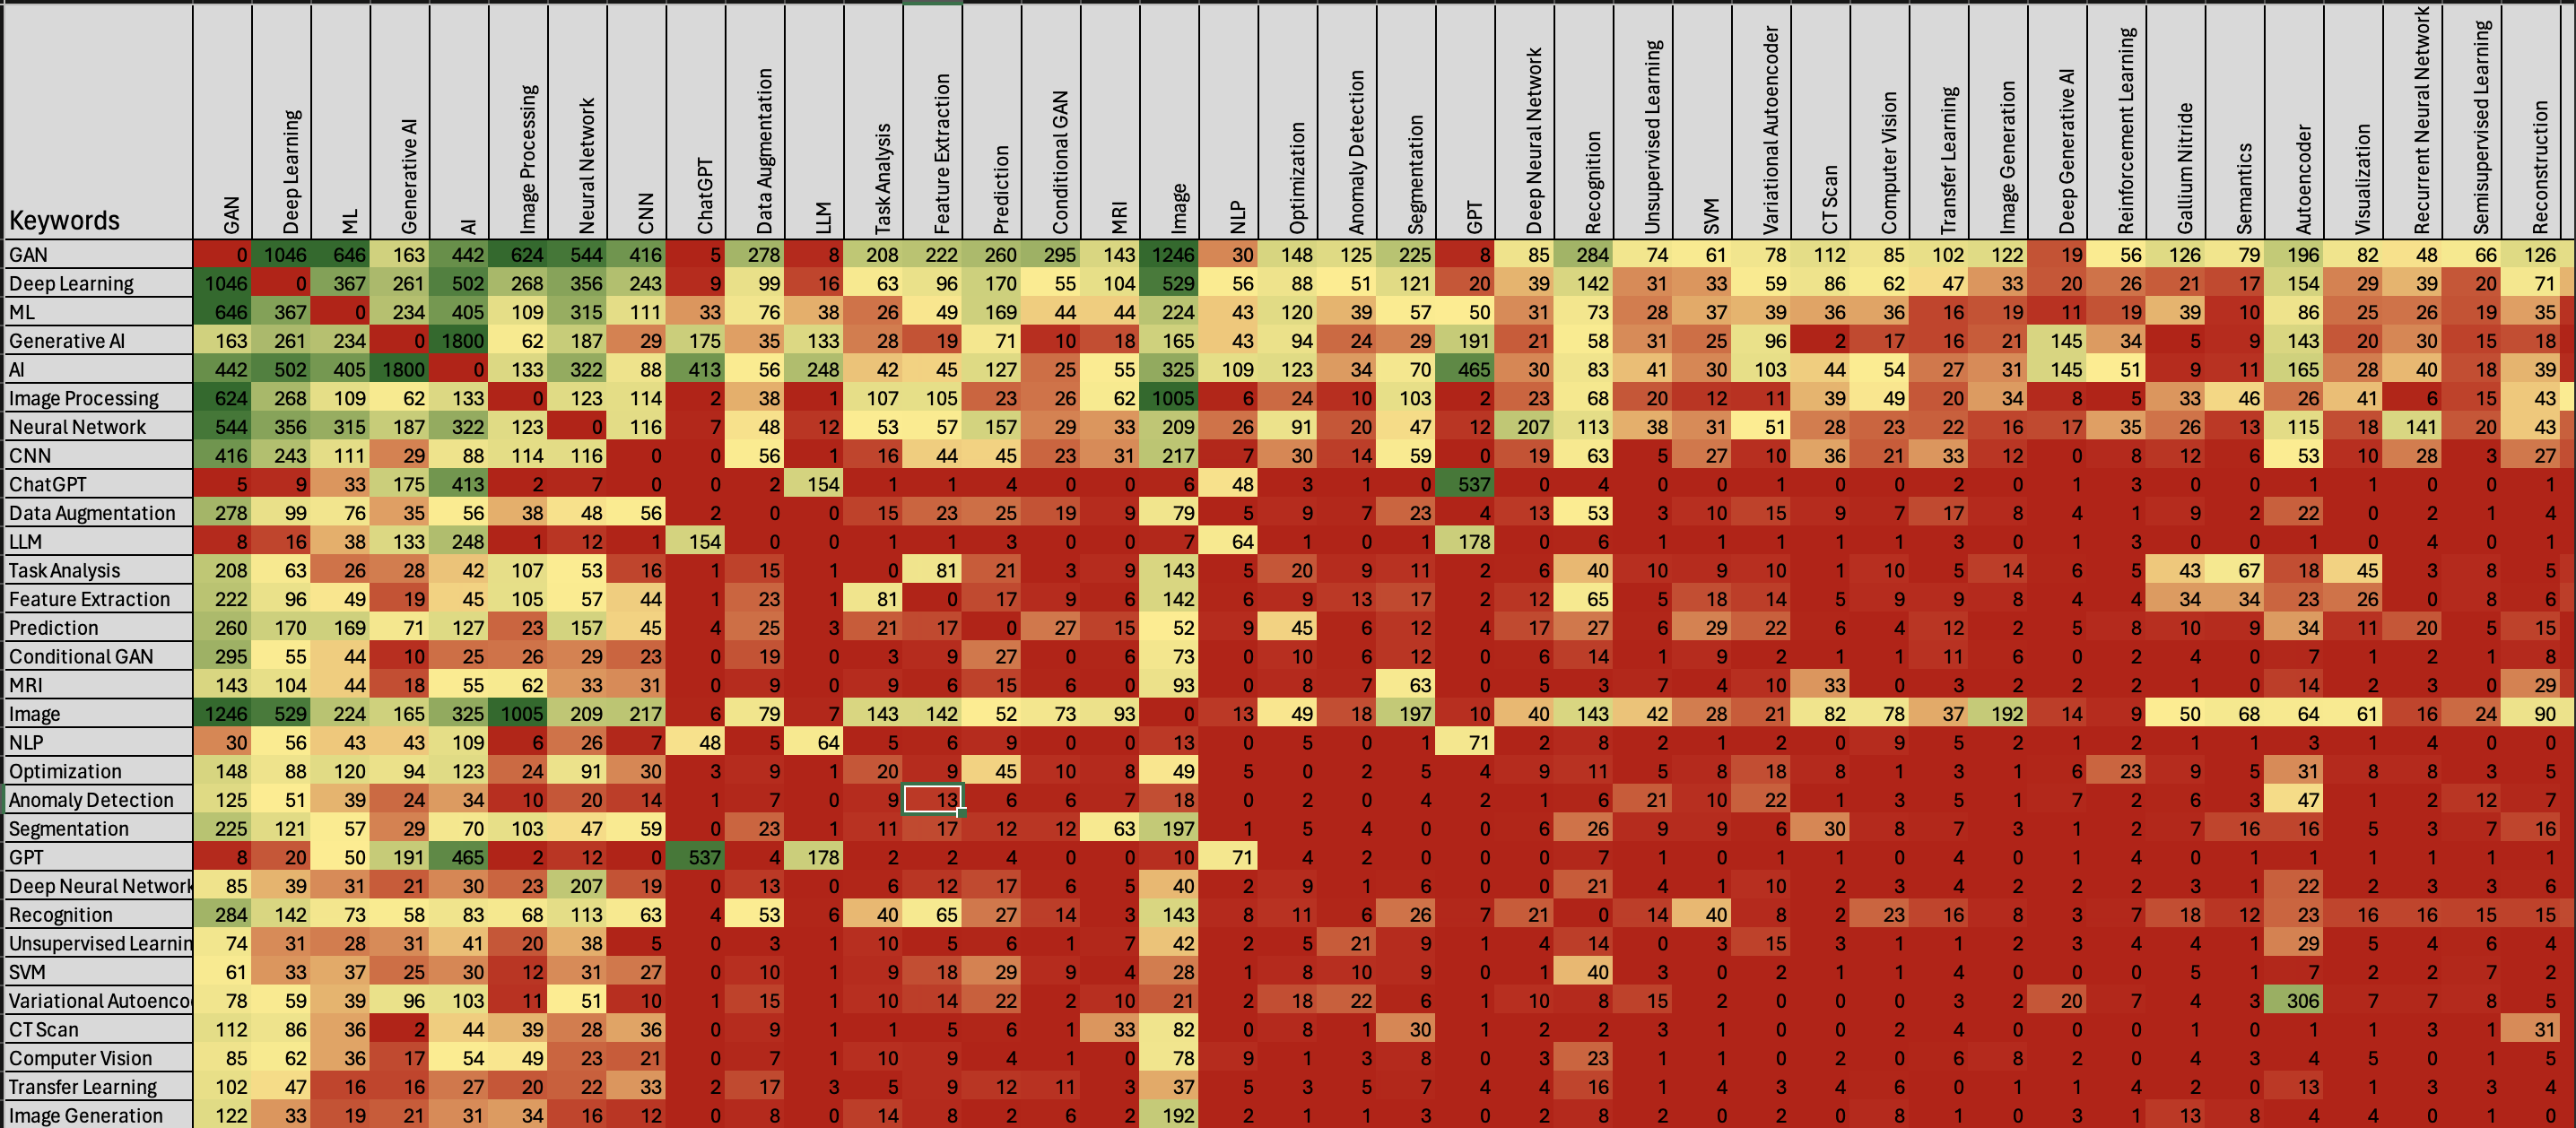

The network graph below shows how the top 20 keywords are linked to each other. The size of the node shows the frequency of a keyword occurrence and the edge length defines the co-occurrence weight of the two keywords linked.

From this keyword network, we can further validate the key findings from the co-occurrence matrix. 'Generative AI' and 'AI' are highly co-occurring and are overlapping. Similarly for the 'GAN', 'Image' and 'GAN',' Deep Learning' keyword pairs.

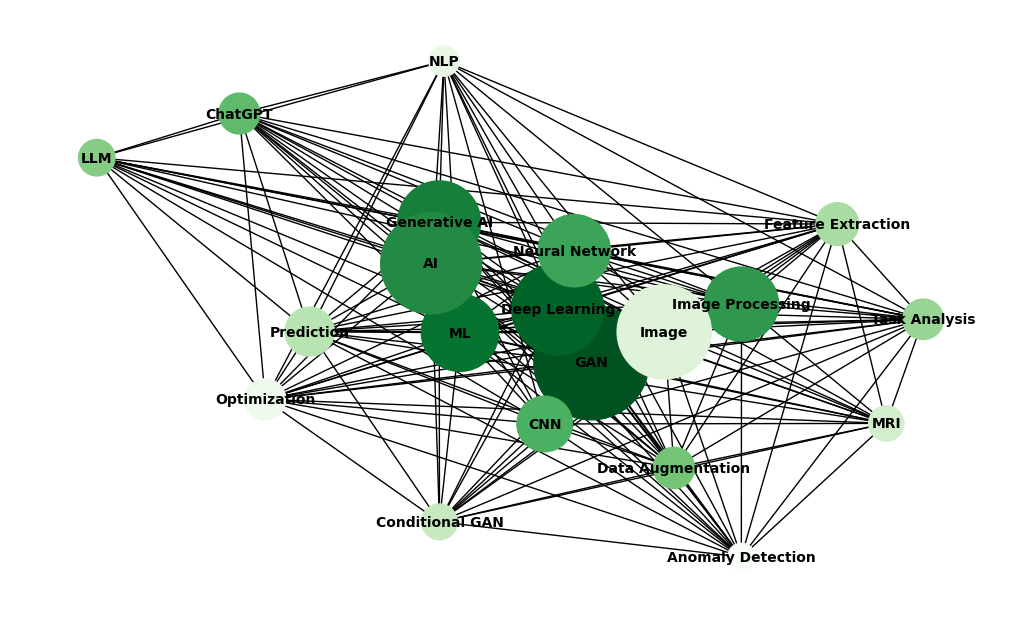

In [62]:
df = create_coocuurance_matrix(top_keywords)
plot_network(df)

### 6. Temporal Analysis on Keywords

To visualize the evolution of different areas of study, we plot a time series chart that shows us the frequency of usage of certain keywords in the articles published over the years. 

As an example, we are using 'Generative AI' as the keyword for the temporal analysis and we see the usage of this keyword has exponentially increased in the year 2023 compared to the previous years. We also see the first occurrence of this keyword was in 2002, and it has gradually increased over the years.

In [66]:
def create_temporal_matrix(keyword):
    # Initialize an empty adjacency matrix
    years = [1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
    m = len(years)
    count_matrix = np.zeros(m, dtype=int)

    # Calculate edit distance between each pair of words
    for i in range(1,m):
        df_y = required_df[required_df['Publication Year']==years[i]]
        for val in df_y['Mapped Keywords']:
            if keyword in val:
                #print(i,years[i],val,'yes')
                count_matrix[i] += 1

    #print(adjacency_matrix)
    df = pd.DataFrame(count_matrix, index=years)

    return df

In [83]:
df = create_temporal_matrix('Generative AI')
fig = px.bar(df,title='Temporal analysis of ''Generative AI'' keyword')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Frequency of occurance")
fig.update_yaxes(title="Year")
fig.show()

### 7. Analysis on research areas

We further analyze the dataset by adding the 'Research area' field, to understand the usage of 'Generative AI' in different fields of studies. This helps in identifying the trends and emerging research fields that use generative AI extensively.

As an example, we are looking at how generative AI is linked to the field of 'Veterinary Sciences'. We see some keywords specific to this field like animal emotion, Livestock health, calves, etc., The keyword calves is far away from all the other keywords and this could mean the 'calves' keyword was mentioned only in 1 or 2 articles and occurs less frequency with the 'Generative AI' related terms. 

We also see an interesting trend where 'Animal emotion' is close to AI keywords, bringing about the idea that AI and ML models are being used in predicting animal emotions.

In [63]:
research_area = required_df[['Research Areas']]
vallist,counts = unique_list_generator(research_area)

research_area_list = vallist

In [64]:
def research_area_network(research_area):
    flag = []

    for val in required_df['Research Areas']:
        if not pd.isna(val):
            if research_area in val:
                flag.append(True)
            else:
                flag.append(False)
        else:
            flag.append(False)

    df_research_area = required_df[flag]
    mapped_keywords = df_research_area[['Mapped Keywords']]

    unique_list,counts = unique_list_generator(mapped_keywords)

    unique_df = pd.DataFrame({'unique_list': unique_list, 'counts': counts})
    unique_df = unique_df.drop(unique_df.index[0])
    unique_df = unique_df.sort_values(by='counts',ascending=False)

    top_keywords = (unique_df['unique_list'].head(20)).to_list()

    df = create_coocuurance_matrix(top_keywords)
    plot_network(df)



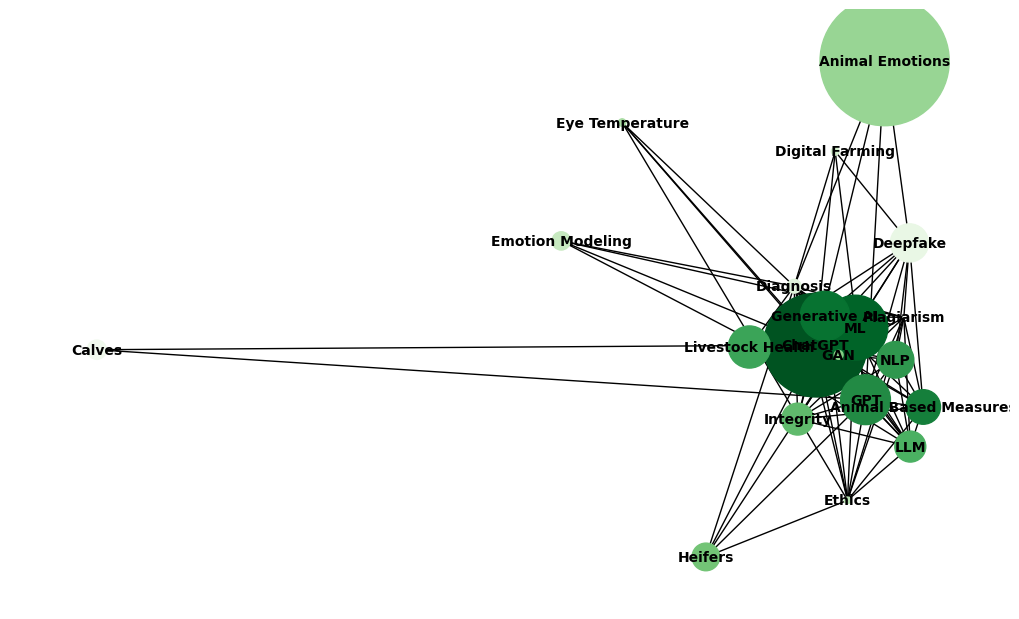

In [65]:
research_area = 'Veterinary Sciences'
research_area_network(research_area)

### 8. Create a dashboard to visualize results

We have created a dashboard that helps us visualize various keywords' and their frequency of usage over the years and the network graph of different research areas, which will highlight the top 20 keywords that are available in that research area and show how these are related to the generative AI related keywords.

Dash app running on http://127.0.0.1:8050/


<IPython.core.display.Javascript object>

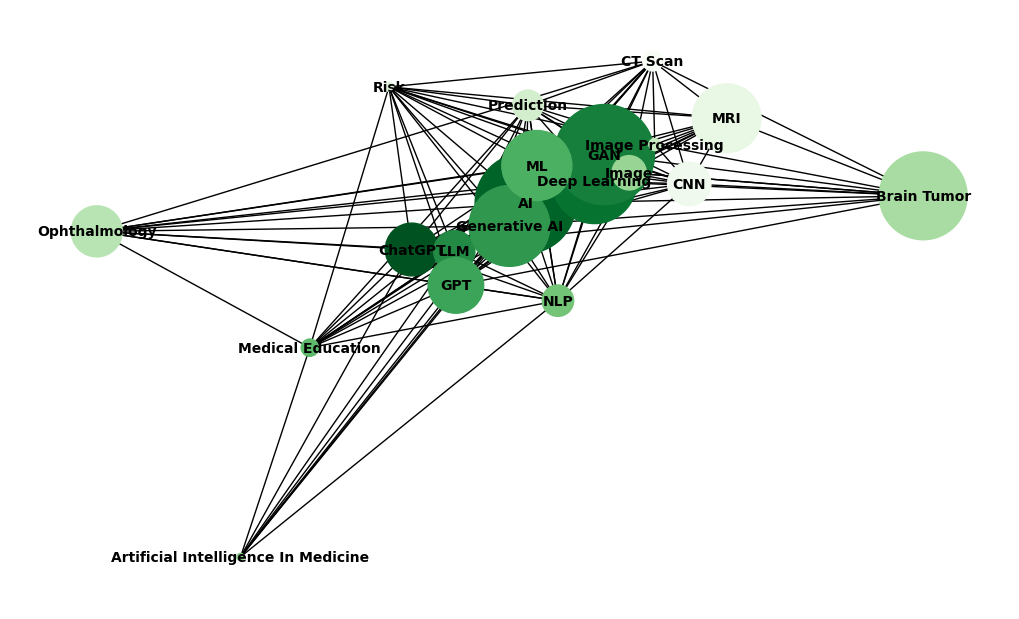

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[84], line 61, in update_graph(value='General & Internal Medicine')
     55 @callback(
     56     Output(component_id='network', component_property='figure'),
     57     Input(component_id='dropdown2', component_property='value')
     58 )
     59 def update_graph(value):
     60     img = research_area_network(value)
---> 61     return plt.imshow(img)
        img = None
        plt = <module 'matplotlib.pyplot' from '/Users/arthikrishnasamy/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

File ~/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py:2695, in imshow(
    X=None,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=

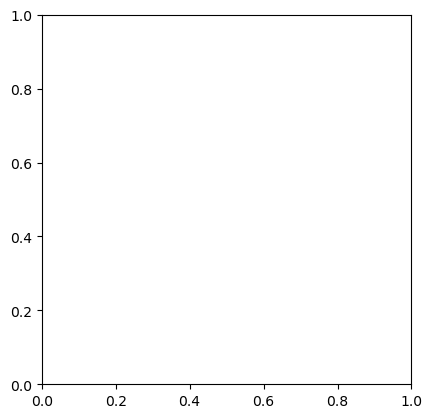

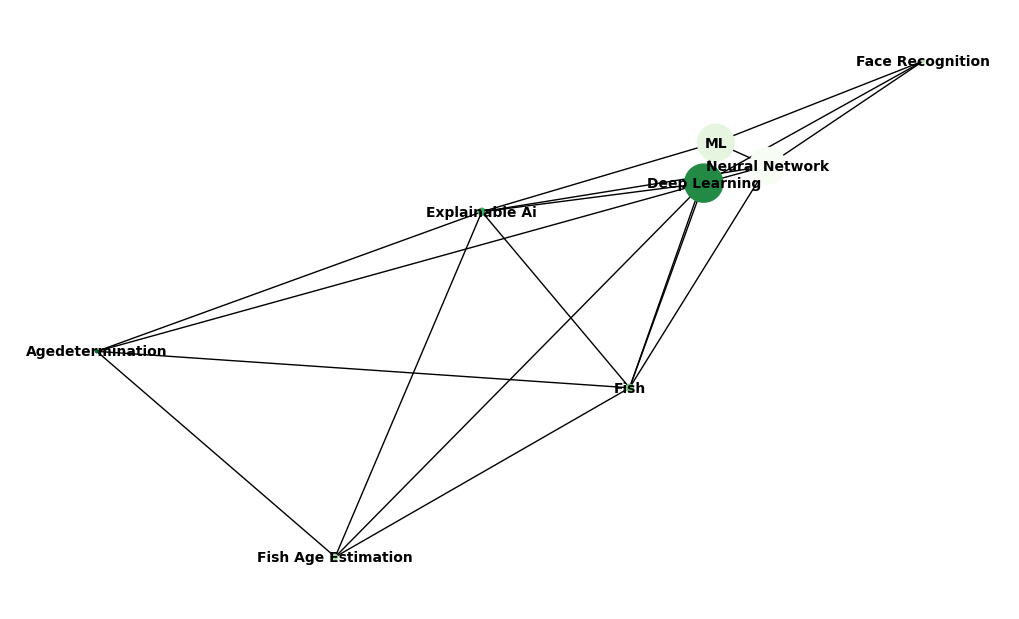

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[84], line 61, in update_graph(value='Fisheries')
     55 @callback(
     56     Output(component_id='network', component_property='figure'),
     57     Input(component_id='dropdown2', component_property='value')
     58 )
     59 def update_graph(value):
     60     img = research_area_network(value)
---> 61     return plt.imshow(img)
        img = None
        plt = <module 'matplotlib.pyplot' from '/Users/arthikrishnasamy/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

File ~/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py:2695, in imshow(
    X=None,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None

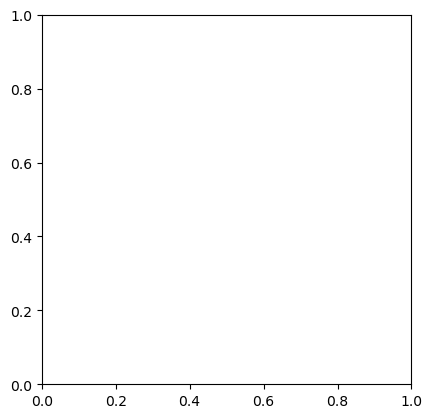

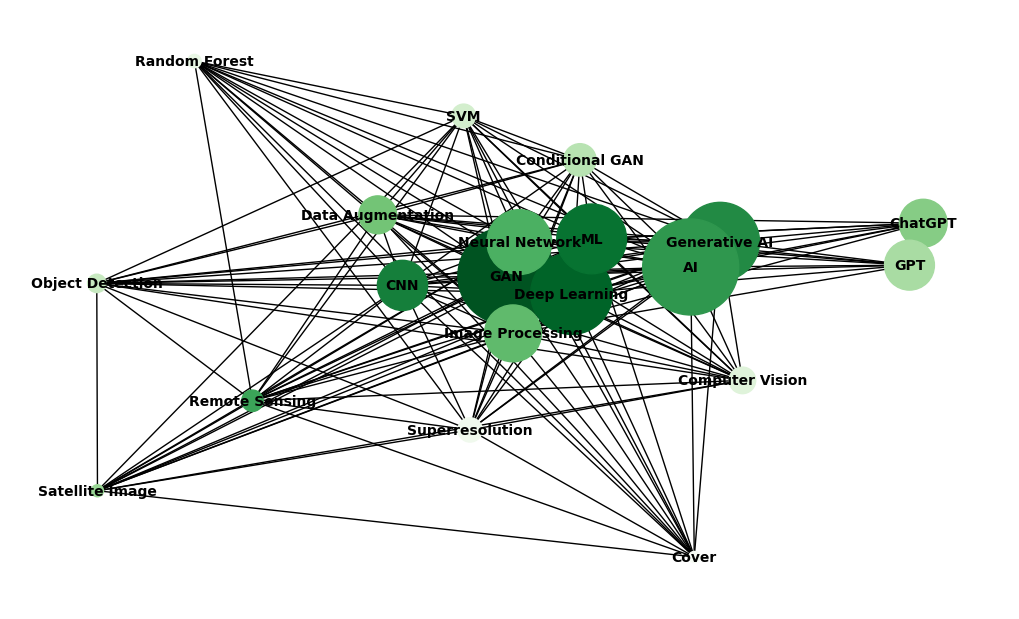

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[84], line 61, in update_graph(
    value='Environmental Sciences & Ecology'
)
     55 @callback(
     56     Output(component_id='network', component_property='figure'),
     57     Input(component_id='dropdown2', component_property='value')
     58 )
     59 def update_graph(value):
     60     img = research_area_network(value)
---> 61     return plt.imshow(img)
        img = None
        plt = <module 'matplotlib.pyplot' from '/Users/arthikrishnasamy/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

File ~/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py:2695, in imshow(
    X=None,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
  

In [ ]:
# Initialize the app - incorporate css
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__, external_stylesheets=external_stylesheets)

# App layout
app.layout = html.Div([
    html.Div(className='row', children='Mapping the Landscape of Generative AI Research through Web of Science',
             style={'textAlign': 'center', 'color': 'black', 'fontSize': 20}),
    
    html.Div(className='row', children='Select Keyword: ',
             style={'textAlign': 'left', 'color': 'black', 'fontSize': 15}),

    html.Div(className='row', children=[
        dcc.Dropdown(
            id="dropdown1",
            options= overall_keywords,
            value="AI",
            clearable=False,)
    ]),
    
    html.Div(className='row', children=[
            dcc.Graph(figure={}, id='temporal')
        ]),
    
    html.Div(className='row', children='Select Research Area: ',
             style={'textAlign': 'left', 'color': 'black', 'fontSize': 15}),
    
    html.Div(className='row', children=[
        dcc.Dropdown(
            id="dropdown2",
            options= research_area_list,
            value='General & Internal Medicine',
            clearable=False,)
    ]),

    html.Div(className='row', children=[
            dcc.Graph(figure={}, id='network')
        ]),
])


# Add controls to build the interaction
@callback(
    Output(component_id='temporal', component_property='figure'),
    Input(component_id='dropdown1', component_property='value')
)
def update_graph(value):
    df = create_temporal_matrix(value)
    fig = px.bar(df,title='Temporal Analysis on' + value)
    fig.update_yaxes(title="Frequency of occurance")
    fig.update_yaxes(title="Year")
    fig.update_layout(showlegend=False)
    return fig

@callback(
    Output(component_id='network', component_property='figure'),
    Input(component_id='dropdown2', component_property='value')
)
def update_graph(value):
    img = research_area_network(value)
    return plt.imshow(img)

# Run the app
if __name__ == '__main__':
    app.run(debug=True, jupyter_mode='tab')

### 9. Conclusion

In this project, we have collected articles related to the term 'Generative AI' from the WOS portal, and combined and processed these article data to create a single data repository. We have collected the author keywords of these articles and cleaned them for further analysis. We then used the cleaned keywords to create a mapping dictionary which helped eliminate repeating keywords and standardize the keyword list. With this list, we created a co-occurrence matrix with 400 top keywords and created a network graph for these top keywords.

We further analyzed the data to include temporal analysis of the keywords and the relevance of generative AI in different research areas. By building an interactive dashboard, we have given the users access to the entire keyword library and analysis. The users can now use this dashboard to derive insights about different areas and their evolution in the area of generative AI.